# Controller Usage

Here we go through a rocket trajectory simulation with canards and roll control. To use controllers and canards, a few things must be added to the simulation.

Let's start by importing the rocketpy module and other necessary modules.

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function
from simple_pid import *
import numpy as np

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [2]:
%matplotlib widget

### Creating a simple Environment

In [3]:
Env = Environment(
    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

Env.setAtmosphericModel(type="CustomAtmosphere")

Launch Site Details

Launch Rail Length: 5.2  m
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1400.0 m


Atmospheric Model Details

Atmospheric Model Type: CustomAtmosphere
CustomAtmosphere Maximum Height: 1.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 180.00°
Surface Wind Heading: 0.00°
Surface Pressure: 855.99 hPa
Surface Temperature: 279.05 K
Surface Air Density: 1.069 kg/m³
Surface Speed of Sound: 334.54 m/s


Atmospheric Model Plots


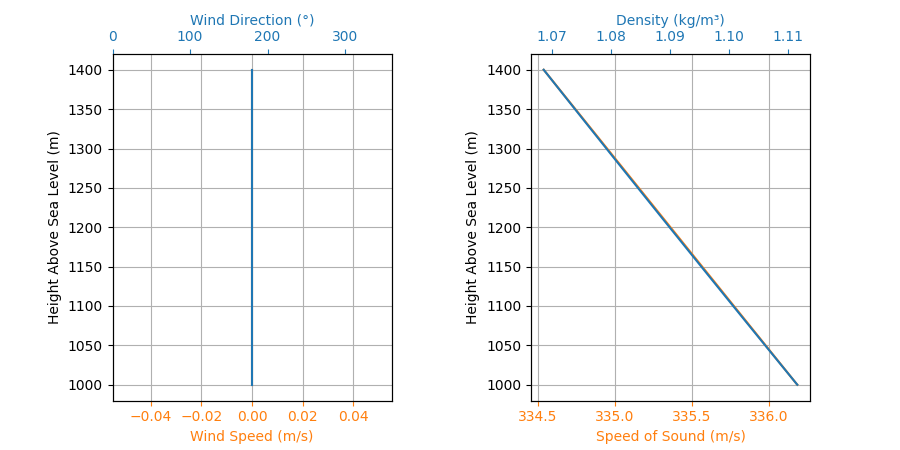

In [4]:
Env.info()

### Creating a Motor

In [5]:
Pro75M1670 = SolidMotor(
    thrustSource="../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
)


Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns

Plots


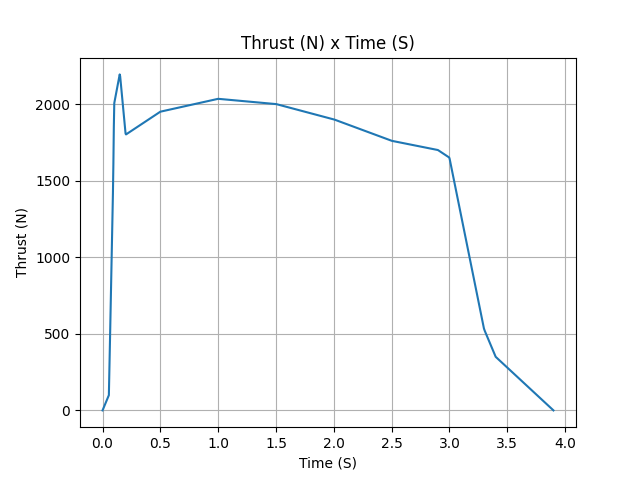

In [6]:
Pro75M1670.info()

### Creating a Rocket

In [7]:
Calisto = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

Calisto.setRailButtons([0.2, -0.5])

#### Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. 
It is important to define the canards as shown bellow so their cant angle can be changed during the simulation

In [8]:
NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(
    4, span=0.130, rootChord=0.130, tipChord=0.040, distanceToCM=-1.04956, cantAngle=1
)

Calisto.canards = Calisto.addFins(
    2, span=0.07, rootChord=0.07, tipChord=0.07, distanceToCM=0.7, cantAngle=0
)

Tail = Calisto.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

Always important to check the static margin to guarantee that the rocket is stable.

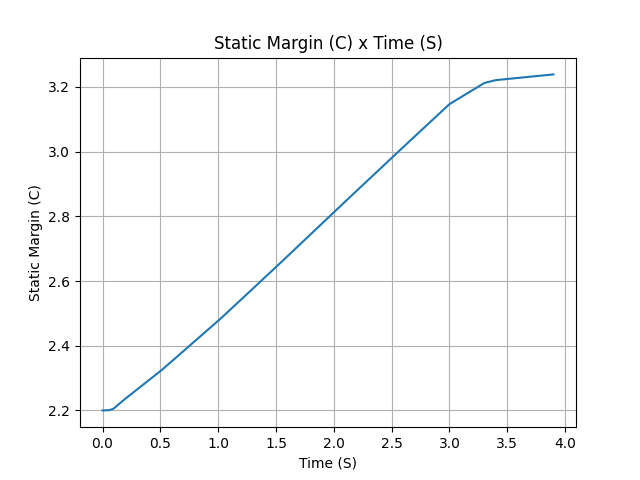

In [9]:
Calisto.staticMargin()

### Defining controller

Here we add the controller to the rocket. Much like adding parachutes, the method call
`Calisto.addControllers` requires a function that defines what the controller will do during flight

In this case, the controller function uses a PID to calculate the cant angle of the 
canards given the roll speed of the rocket (omega3). It activates only after the motor burn out.

Here there are a few global variables used for checking how the cantAngle and omega3 behaved during the flight simulation

In [17]:
#TODO: better way to save cantAngleList and omegaList

cantAngleList = []
omegaList = []

# defines PID controller
pid = PID(
    Kp=0.015,
    Ki=0.0315,
    Kd=0.000,
    sample_time=None,
    output_limits=(-np.radians(8), np.radians(8)),
)

# TODO: make controller attributes accessible in the controllerFunction

def controllerFunction(flightClassInstance):
    global cantAngleList
    global omegaList
    global pid

    rocket = flightClassInstance.rocket
    omega3 = flightClassInstance.y[-1]
    time = flightClassInstance.t
    servo_speed = 60/0.8 # degrees per second

    # Checks if the motor has fineshed burning
    if time < rocket.motor.burnOutTime:
        return

    # PID controller receives omega and returns delta
    cantAngleRad = pid(omega3, dt=1 / 100) 

    cantAngle = cantAngleRad*180/np.pi

    rocket.canards = rocket.changeCantAngle(cantAngle, rocket.canards)
    cantAngleList.append([time, cantAngle])
    omegaList.append([time, omega3])

    
# Clear controller list so that this cell can be rerun without rerunning the Rocket class
# cells above.
Calisto.controllers = []
    
Calisto.addController(name='CanardPID', controllerFunction=controllerFunction, samplingRate=100, lag=0)

The last

In [18]:
# cantAngleList = []
# omegaList = []

# # defines PID controller
# pid = PID(
#     Kp=0.015,
#     Ki=0.0315,
#     Kd=0.000,
#     sample_time=None,
#     output_limits=(-np.radians(8), np.radians(8)),
# )

# # TODO: make controller attributes accessible in the controllerFunction

# def controllerFunction(flightClassInstance):
#     global cantAngleList
#     global omegaList
#     global pid

#     rocket = flightClassInstance.rocket
#     omega3 = flightClassInstance.y[-1]
#     time = flightClassInstance.t
#     servo_speed = 60/0.8 # degrees per second

#     # Checks if the motor has fineshed burning
#     if time < rocket.motor.burnOutTime:
#         return

#     # PID controller receives omega and returns delta
#     cantAngleRad = pid(omega3, dt=1 / 100) 

#     cantAngle = cantAngleRad*180/np.pi

#     maximumCantAngleChange = servo_speed*1/100 # degrees per second

#     rocket.canards = rocket.changeCantAngle(cantAngle, rocket.canards, maximumCantAngleChange)
#     cantAngleList.append([time, cantAngle])
#     omegaList.append([time, omega3])

    


# # Clear controller list so that this cell can be rerun without rerunning the Rocket class
# # cells above.
# Calisto.controllers = []
    
# Calisto.addController(name='CanardPID', controllerFunction=controllerFunction, samplingRate=100, lag=0)

## Simulating a Flight

We can then simulate the flight and check the relevant information

In [19]:
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0, timeOvershoot=False, terminateOnApogee=True)

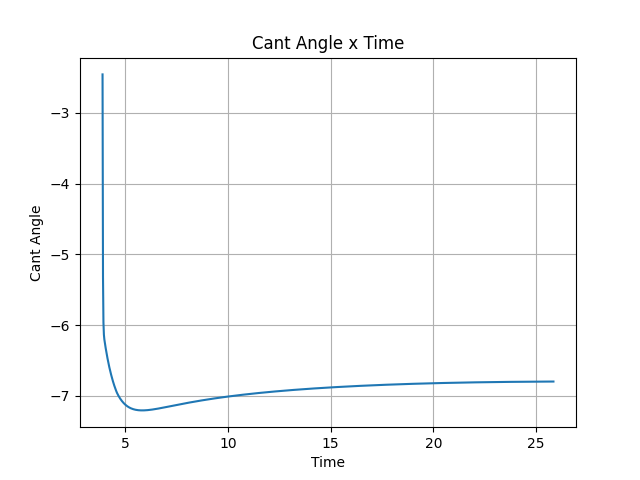

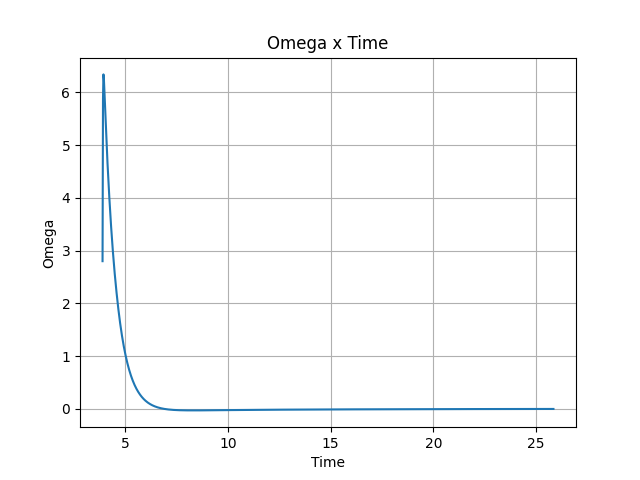

In [20]:
Function(cantAngleList,'time','cant Angle',interpolation='linear')()
Function(omegaList,'time','omega',interpolation='linear')()

In [21]:
TestFlight.info()

Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


 Rail Departure State

Rail Departure Time: 0.363 s
Rail Departure Velocity: 25.796 m/s
Rail Departure Static Margin: 1.142 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 10.143
Rail Departure Reynolds Number: 2.008e+05


BurnOut State

BurnOut time: 3.900 s
Altitude at burnOut: 657.220 m (AGL)
Rocket velocity at burnOut: 279.526 m/s
Freestream velocity at burnOut: 279.526 m/s
Mach Number at burnOut: 0.842
Kinetic energy at burnOut: 6.345e+05 J


Apogee

Apogee Altitude: 4699.652 m (ASL) | 3299.652 m (AGL)
Apogee Time: 25.841 s
Apogee Freestream Speed: 20.603 m/s


Events

No Parachute Events Were Triggered.


Impact

X Impact: 0.000 m
Y Impact: 0.000 m
Time of Impact: 25.841 s
Velocity at Impact: 0.000 m/s


Maximum Values

Maximum Speed: 285.848 m/s at 3.38 s
Maximum Mach Number: 0.860 Mach at 3.39 s
Maximum Reynolds Number: 2.138e+06 at 3.32 s
Maximum Dy

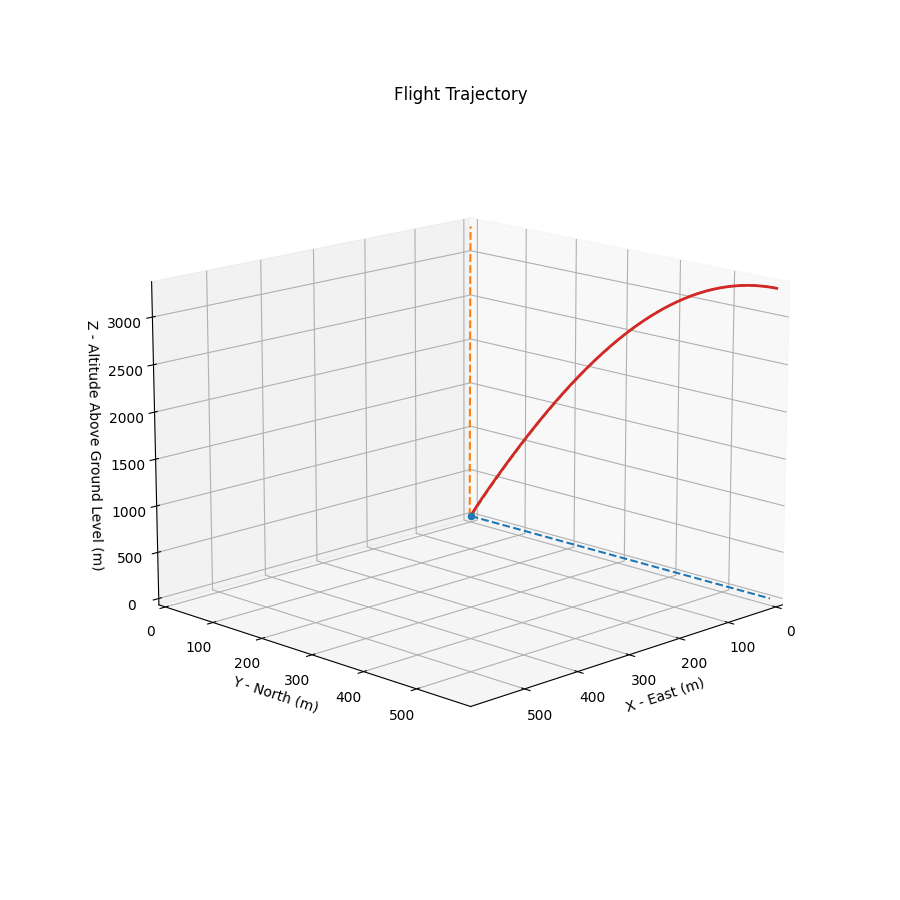

In [22]:
TestFlight.plot3dTrajectory()